In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom

The Shepp-Logan phantom contains 6 gray levels.


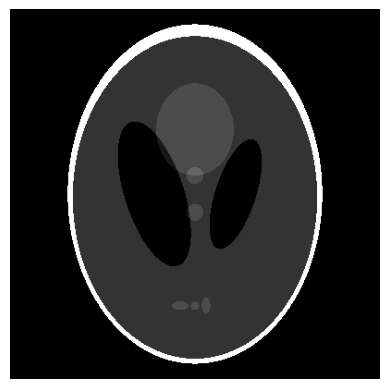

In [2]:
# Load the Shepp-Logan phantom
image = shepp_logan_phantom()

# Determine the number of gray levels in the image
num_gray_levels = len(np.unique(image))
print(f'The Shepp-Logan phantom contains {num_gray_levels} gray levels.')

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

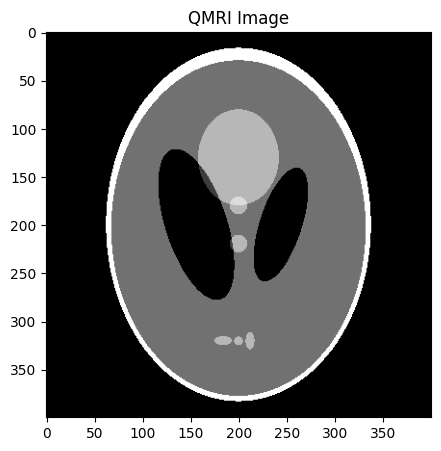

In [3]:
# Load the qmri data
qmri_data = np.load('qmri.npy')

# Take the mean along the z-axis to obtain a 2D image
qmri_data_2d = np.mean(qmri_data, axis=2)

# Display the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(qmri_data_2d, cmap='gray')
ax.set_title('QMRI Image')
plt.show()

In [4]:
def compute_r2star(image, echo_times):
    # Flatten the image into a 2D array
    data = np.reshape(image, (-1, image.shape[-1]))
    
    # Compute the logarithm of the signal intensity
    log_data = np.log(data)
    
    # Fit a linear regression to the log data for each voxel
    slopes = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        slope, _ = np.polyfit(echo_times, log_data[i], 1)
        slopes[i] = slope
        
    # Compute R2* from the slopes
    r2star = -1.0 / slopes
    
    # Reshape R2* into the original image shape
    r2star_image = np.reshape(r2star, image.shape[:-1])
    
    return r2star_image


In [7]:
def compute_contrast_matrix(image, echo_times):
    num_echos = len(echo_times)
    contrast_matrix = np.zeros((num_echos, num_echos))
    for i in range(num_echos):
        for j in range(num_echos):
            contrast_matrix[i,j] = np.max(image[:,:,i] - image[:,:,j])
    max_contrast = np.max(contrast_matrix)
    max_contrast_echoes = np.where(contrast_matrix == max_contrast)
    max_contrast_echo1 = echo_times[max_contrast_echoes[0][0]]
    max_contrast_echo2 = echo_times[max_contrast_echoes[1][0]]
    return contrast_matrix, max_contrast, max_contrast_echo1, max_contrast_echo2

contrast_matrix, max_contrast, max_contrast_echo1, max_contrast_echo2 = compute_contrast_matrix(qmri_data, echo_times)
print('Maximum contrast value: ', max_contrast)
print('Echo time 1 with maximum contrast: ', max_contrast_echo1)
print('Echo time 2 with maximum contrast: ', max_contrast_echo2)

Maximum contrast value:  0.9998765901959134
Echo time 1 with maximum contrast:  10
Echo time 2 with maximum contrast:  100


C:\Users\hp\AppData\Local\Temp\ipykernel_6436\2971439693.py:6: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(data)


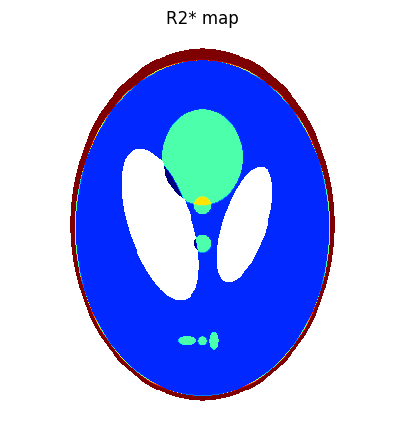

In [6]:
qmri_data = np.load('qmri.npy')
echo_times = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
r2star_map = compute_r2star(qmri_data, echo_times)
compute_contrast_matrix(qmri_data, echo_times)

# Display R2* map
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(r2star_map, cmap='jet')
ax.set_title('R2* map')
ax.axis('off')
plt.show()

In [9]:
def compute_t2star(signal, echo_times):
    # Convert the echo times to a column vector
    TE = echo_times.reshape(-1, 1)

    # Take the natural logarithm of the signal intensities
    S = np.log(signal)

    # Compute a linear fit to the natural logarithm of the signal
    p = np.polyfit(TE.ravel(), S.T, 1)

    # Extract the slope and convert to T2*
    T2s = -1 / p[0, :]

    # Return the T2* map
    return T2s.reshape(signal.shape[:-1])


In [15]:
# Load the non-noisy T2* map and the noisy T2* map
t2s_clean = np.load('qmri.npy')
t2s_noisy = np.load('qmri_noised.npy')
echo_times = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Remove the last dimension of t2s_noisy
t2s_noisy_3d = t2s_noisy[..., 0]
t2s_clean_3d = t2s_clean[..., 0]

# Generate a noisy T2* map
noisy_t2star = compute_t2star(t2s_noisy_3d, echo_times)

# Compute the non-noisy T2* map
t2star = compute_t2star(t2s_clean_3d, echo_times)

# Compute the absolute difference between the noisy and non-noisy T2* maps
error_map = np.abs(t2star - noisy_t2star)

# Display the error map
plt.imshow(error_map, cmap='hot')
plt.colorbar()
plt.show()


TypeError: expected x and y to have same length